In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [139]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from Model.DataLoader import DataLoaderManager
from Model.Train import Trainer
from Model.Loss import Loss
from Model.Test import Tester

## Constants

In [140]:
epochs = 100
image_size = 224
num_classes = 1
learning_rate = 1e-4
train_size = 0.8
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data loading

Number of files : 663
Number of files : 663
Shape of the input data: 
torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
Min and Max of the input data: 
tensor(-1.) tensor(1.) tensor(0.) tensor(1.)


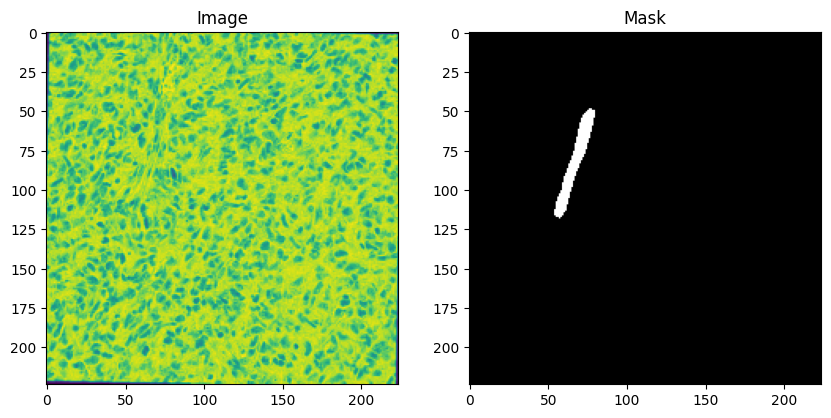

Shape of the input data: 
torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
Min and Max of the input data: 
tensor(-1.) tensor(1.) tensor(0.) tensor(1.)


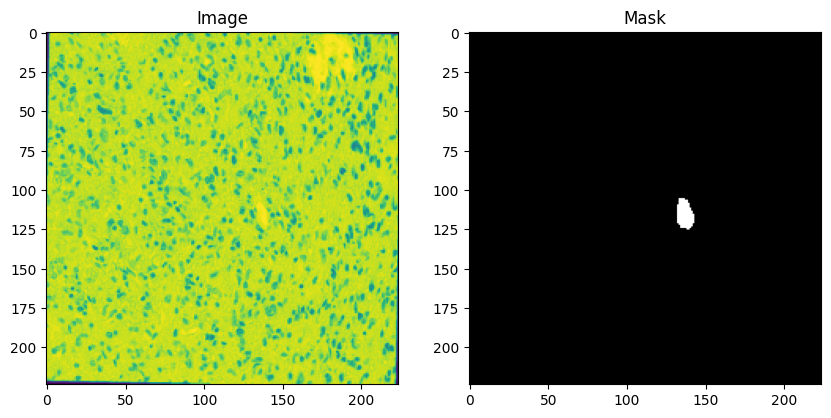

Shape of the input data: 
torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
Min and Max of the input data: 
tensor(-0.8510) tensor(1.) tensor(0.) tensor(1.)


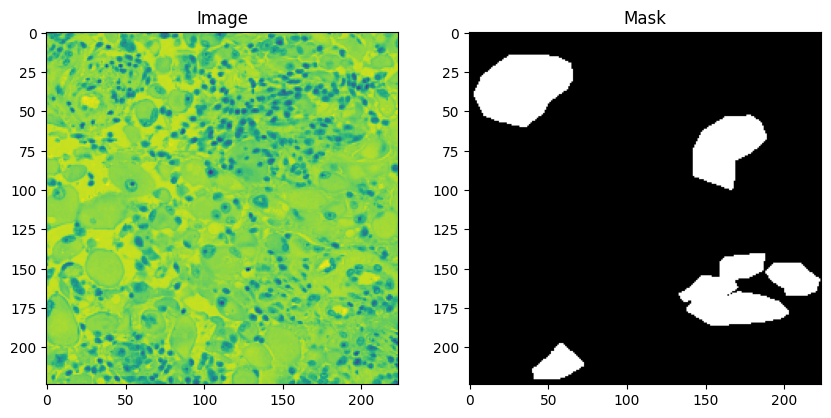

Train size : 34
Validation size : 9
Test size : 4


In [141]:
dataset = DataLoaderManager(
    root_dir="../patches", kidney_dir=None, data_augmentation=True, shape=(image_size,image_size), 
    test_dir="../patches/patches_test/patches_anno_medecin_bvd_mask"
)

test_set = DataLoaderManager(
    root_dir="../patches/patches_test", test_set=True, 
    shape=(image_size,image_size), test_dir="../patches/patches_test/patches_anno_medecin_bvd_mask"
)

train_size = int(train_size * len(dataset))
val_size = len(dataset) - train_size 

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

dataset.show_data(train_loader)
dataset.show_data(val_loader)
dataset.show_data(test_loader)

print(f"Train size : {len(train_loader)}")
print(f"Validation size : {len(val_loader)}")
print(f"Test size : {len(test_loader)}")

## Model Training
- Encoder can be one of : 
    - 'vgg16', 'vgg19', 
    - 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
    - 'efficientnet-b3'


In [ ]:
encoder_name = 'efficientnet-b3'
model = smp.Unet(encoder_name=encoder_name, encoder_weights='imagenet', classes=num_classes, in_channels=3)
model = model.to(device)
optimizer = torch.optim.AdamW
loss = Loss.combined_bce_loss
trainer = Trainer()
pos_weight = trainer.calculate_weights(train_loader)
print(f"Positive weights : {pos_weight}")
history = trainer.set_model(model)\
    .set_loader(train_loader, val_loader, test_loader)\
    .set_loss_fn(loss)\
    .set_optimizer(optimizer)\
    .fit(learning_rate, epochs, 1/pos_weight)

## Model saving 
- Path explanation : 
    - [MODEL NAME]\_[MODEL VERSION]\_[LOSS]\_[OPTIMIZER]\_[WEIGHTED CLASS]\_[AUGMENTED DATA]\_[IMAGE_CHANNELS]\_[NUMBER CLUSTERS]\_[NUMBER EPOCHS]

In [129]:
suffix = "model_ENB3_BCE_DICE_balanced_augmented_3D"

model_path = f"../res/model_params/model_with_bce_dice/{suffix}"
history_path = f"../res/model_metrics/model_with_bce_dice{suffix}"

trainer.save(model_path, history_path)

## Plotting results

In [ ]:
train_loss = history['training']['loss']
val_loss = history['validation']['loss']
precision = history['training']['precision']
recall = history['training']['recall']
val_p = history['validation']['precision']
val_r = history['validation']['recall']

trainer.plot_loss(train_loss, val_loss)
trainer.plot_precision_recall(precision, recall, val_p, val_r)

## Testing

Testing the model
Accuracy: 0.9475977891156463, Precision: 0.9627682633581176, Recall: 0.10273441882280707, F1 Score: 0.18565779261050128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


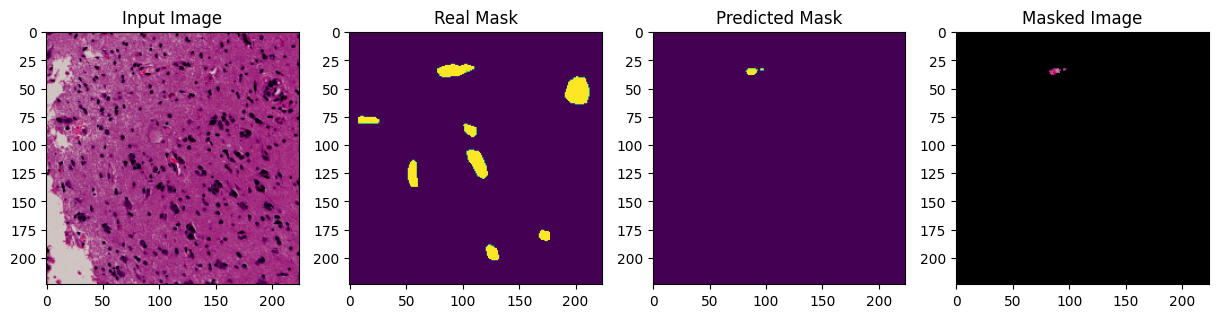

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


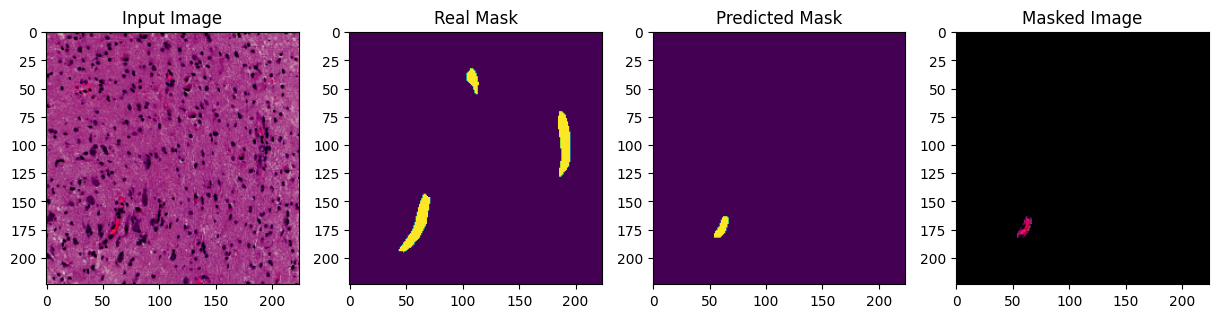

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


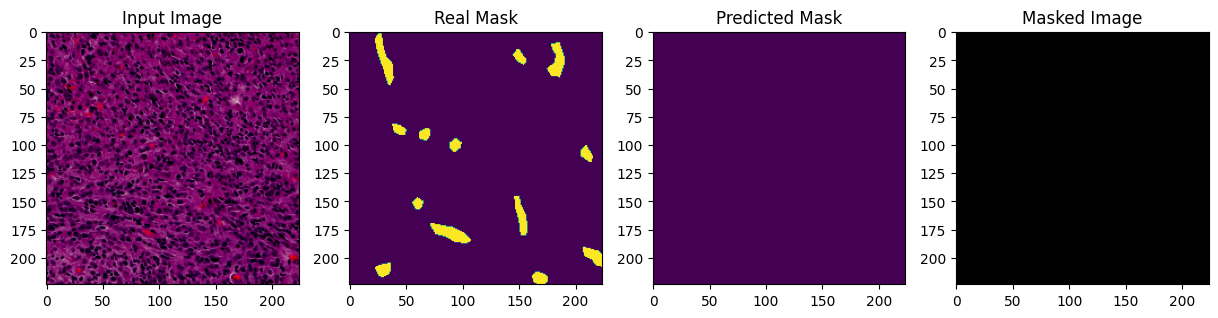

In [142]:
tester = Tester(state=model_path, test_loader=test_loader)
tester.evaluate()
tester.predict_loader(test_loader, max_images=3, has_target=True)